<a href="https://colab.research.google.com/github/XUANHAOC/DASC6510F2023Project/blob/main/6510_time_NNAR%2BX%2Bweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('/content/ETTh1.csv')
df.head()


import numpy as np


for lag in range(1, 26):
    df[f'lag_{lag}'] = df['OT'].shift(lag)

# 删除由于创建滞后特征而产生的缺失值行
# Remove rows with missing values due to creating lagged features
df.dropna(inplace=True)

# 计算训练集和测试集的分割点
# Calculate the split points between the training set and the test set
split_index = int(len(df) * 0.95)

# 分割训练集和测试集
# Split training set and test set
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# 从训练集和测试集中提取NNAR和MLP的输入
# Extract the input of NNAR and MLP from the training set and test set
train_nnar_inputs = train_df[[f'lag_{i}' for i in range(1, 26)]]
train_mlp_inputs = train_df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']]
train_targets = train_df['OT']

test_nnar_inputs = test_df[[f'lag_{i}' for i in range(1, 26)]]
test_mlp_inputs = test_df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']]
test_targets = test_df['OT']


In [10]:
train_nnar_inputs.head

<bound method NDFrame.head of            lag_1      lag_2      lag_3      lag_4      lag_5      lag_6  \
25     21.104000  19.768000  18.009001  18.009001  17.868000  18.712000   
26     19.697001  21.104000  19.768000  18.009001  18.009001  17.868000   
27     20.049000  19.697001  21.104000  19.768000  18.009001  18.009001   
28     20.752001  20.049000  19.697001  21.104000  19.768000  18.009001   
29     21.385000  20.752001  20.049000  19.697001  21.104000  19.768000   
...          ...        ...        ...        ...        ...        ...   
16545   6.050000   5.979000   5.909000   6.050000   5.698000   5.628000   
16546   6.472000   6.050000   5.979000   5.909000   6.050000   5.698000   
16547   6.402000   6.472000   6.050000   5.979000   5.909000   6.050000   
16548   6.402000   6.402000   6.472000   6.050000   5.979000   5.909000   
16549   6.753000   6.402000   6.402000   6.472000   6.050000   5.979000   

           lag_7      lag_8      lag_9     lag_10  ...     lag_16    

In [11]:
test_nnar_inputs.head

<bound method NDFrame.head of         lag_1   lag_2   lag_3   lag_4   lag_5  lag_6  lag_7  lag_8  lag_9  \
16550   7.105   6.753   6.402   6.402   6.472  6.050  5.979  5.909  6.050   
16551   7.175   7.105   6.753   6.402   6.402  6.472  6.050  5.979  5.909   
16552   7.316   7.175   7.105   6.753   6.402  6.402  6.472  6.050  5.979   
16553   5.628   7.316   7.175   7.105   6.753  6.402  6.402  6.472  6.050   
16554   4.432   5.628   7.316   7.175   7.105  6.753  6.402  6.402  6.472   
...       ...     ...     ...     ...     ...    ...    ...    ...    ...   
17415  10.200   9.426   9.215   9.215   8.934  9.075  9.426  9.638  9.286   
17416  10.904  10.200   9.426   9.215   9.215  8.934  9.075  9.426  9.638   
17417  11.044  10.904  10.200   9.426   9.215  9.215  8.934  9.075  9.426   
17418  10.271  11.044  10.904  10.200   9.426  9.215  9.215  8.934  9.075   
17419   9.778  10.271  11.044  10.904  10.200  9.426  9.215  9.215  8.934   

       lag_10  ...  lag_16  lag_17  lag_18  l

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
#我们已经在R中构建了NNAR模型，，并且得到最好的模型参数。
#我们将使用NNAR最好的结构我们结合模型中。然后对于X参数的MLP结构，我们还没有任何的参数值。
#我们使用GridSearchCV和MLPRegressor 帮助我们快速地确认 只使用x预测Y时最好的参数值。
#We have built the NNAR model in R and obtained the best model parameters.
#We will use the best structure of NNAR in our combined model.
#Then for the MLP structure of the X parameter, we don't have any parameter values yet.
#We use GridSearchCV and MLPRegressor to help us quickly
#identify the best parameter values when predicting Y using only x.


# 转换为Numpy数
# Convert to Numpy number
X_train = train_mlp_inputs.to_numpy()
y_train = train_targets.to_numpy()

# 定义MLPRegressor
#Define MLPRegressor
mlp = MLPRegressor(max_iter=200)

# 定义要测试的参数网格
# Define the parameter grid to be tested
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# 使用GridSearchCV
# Use GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train.ravel())

# 打印最佳参数集
# Print the best parameter set
print('Best parameters found:\n', clf.best_params_)

# 在训练集上进行预测
# Make predictions on the training set
y_pred = clf.predict(X_train)

# 计算均方误差
# Calculate mean square error
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error on training set:", mse)


Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
Mean Squared Error on training set: 47.192298220605274


In [11]:
from torch.utils.data import TensorDataset, DataLoader

# train_nnar_inputs, train_mlp_inputs 和 train_targets 已经是Pandas DataFrame
# 首先将它们转换为PyTorch张量
# train_nnar_inputs, train_mlp_inputs and train_targets are already Pandas DataFrames
# First convert them to PyTorch tensors
train_nnar_inputs_tensor = torch.tensor(train_nnar_inputs.values, dtype=torch.float32)
train_mlp_inputs_tensor = torch.tensor(train_mlp_inputs.values, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets.values, dtype=torch.float32).view(-1, 1)

# TensorDataset
train_dataset = TensorDataset(train_nnar_inputs_tensor, train_mlp_inputs_tensor, train_targets_tensor)

# DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)




In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
num_epochs = 100

class NNARModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNARModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x


class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)  # 100
        self.relu = nn.ReLU()  # ReLU
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)  # ReLU
        x = self.fc2(x)
        return x
'''
class CombinedModel(nn.Module):
    def __init__(self, nnar_model, mlp_model):
        super(CombinedModel, self).__init__()
        self.nnar_model = nnar_model
        self.mlp_model = mlp_model
        self.fc = nn.Linear(2, 1)
        self.relu = nn.ReLU()
        #self.sigmoid = nn.Sigmoid()

    def forward(self, nnar_input, mlp_input):
        nnar_output = self.nnar_model(nnar_input)
        mlp_output = self.mlp_model(mlp_input)
        combined = torch.cat((nnar_output, mlp_output), dim=1)
        x = self.fc(combined)
        x = self.relu(x)
        #x = self.sigmoid(x)
        return x
'''
class CombinedModel(nn.Module):
    def __init__(self, nnar_model, mlp_model):
        super(CombinedModel, self).__init__()
        self.nnar_model = nnar_model
        self.mlp_model = mlp_model
        self.fc_weight = nn.Linear(1, 1)  # for weight
        self.sigmoid = nn.Sigmoid()  # weight 0-1

        self.nnar_activation = nn.ReLU()
        self.mlp_activation = nn.ReLU()

    def forward(self, nnar_input, mlp_input):
        #nnar_output = self.nnar_model(nnar_input)
        #mlp_output = self.mlp_model(mlp_input)
        nnar_output = self.nnar_activation(self.nnar_model(nnar_input))
        mlp_output = self.mlp_activation(self.mlp_model(mlp_input))


        weight = self.sigmoid(self.fc_weight(torch.ones_like(nnar_output)))


        combined_output = weight * nnar_output + (1 - weight) * mlp_output
        return combined_output


x_dim = train_mlp_inputs.shape[1]

nnar_model = NNARModel(input_dim=25, hidden_dim=13)
mlp_model = MLPModel(input_dim=x_dim)
combined_model = CombinedModel(nnar_model, mlp_model)

# 定义损失函数和优化器
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    for nnar_data, mlp_data, targets in train_loader:
        optimizer.zero_grad()
        combined_output = combined_model(nnar_data, mlp_data)
        loss = criterion(combined_output, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    if epoch % 10 == 9 or epoch == num_epochs - 1:
        weight = combined_model.sigmoid(combined_model.fc_weight(torch.ones_like(nnar_output))).data
        print(f'Epoch {epoch+1}, Weight: {weight.item()}')

Epoch 1/100, Loss: 94.29683685302734
Epoch 2/100, Loss: 115.12265014648438
Epoch 3/100, Loss: 33.0053825378418
Epoch 4/100, Loss: 65.36884307861328
Epoch 5/100, Loss: 32.63993453979492
Epoch 6/100, Loss: 48.97021484375
Epoch 7/100, Loss: 28.072500228881836
Epoch 8/100, Loss: 5.979126930236816
Epoch 9/100, Loss: 19.526018142700195
Epoch 10/100, Loss: 11.15447998046875
Epoch 10, Weight: 0.8337329030036926
Epoch 11/100, Loss: 12.77023983001709
Epoch 12/100, Loss: 1.7427527904510498
Epoch 13/100, Loss: 1.111197590827942
Epoch 14/100, Loss: 1.7792437076568604
Epoch 15/100, Loss: 2.7079386711120605
Epoch 16/100, Loss: 4.405202865600586
Epoch 17/100, Loss: 7.498407363891602
Epoch 18/100, Loss: 1.695000171661377
Epoch 19/100, Loss: 1.4971474409103394
Epoch 20/100, Loss: 2.7455127239227295
Epoch 20, Weight: 0.9319055080413818
Epoch 21/100, Loss: 2.4860517978668213
Epoch 22/100, Loss: 2.0298550128936768
Epoch 23/100, Loss: 0.9503793716430664
Epoch 24/100, Loss: 2.1709775924682617
Epoch 25/100, L

In [85]:
# eval for test
combined_model.eval()

# test no_grad
with torch.no_grad():

    test_nnar_inputs_tensor = torch.tensor(test_nnar_inputs.values, dtype=torch.float32)
    test_mlp_inputs_tensor = torch.tensor(test_mlp_inputs.values, dtype=torch.float32)
    test_targets_tensor = torch.tensor(test_targets.values, dtype=torch.float32).view(-1, 1)


    test_predictions = combined_model(test_nnar_inputs_tensor, test_mlp_inputs_tensor)


    test_loss = criterion(test_predictions, test_targets_tensor)
    print(f'Test Loss: {test_loss.item()}')


Test Loss: 0.3186185359954834


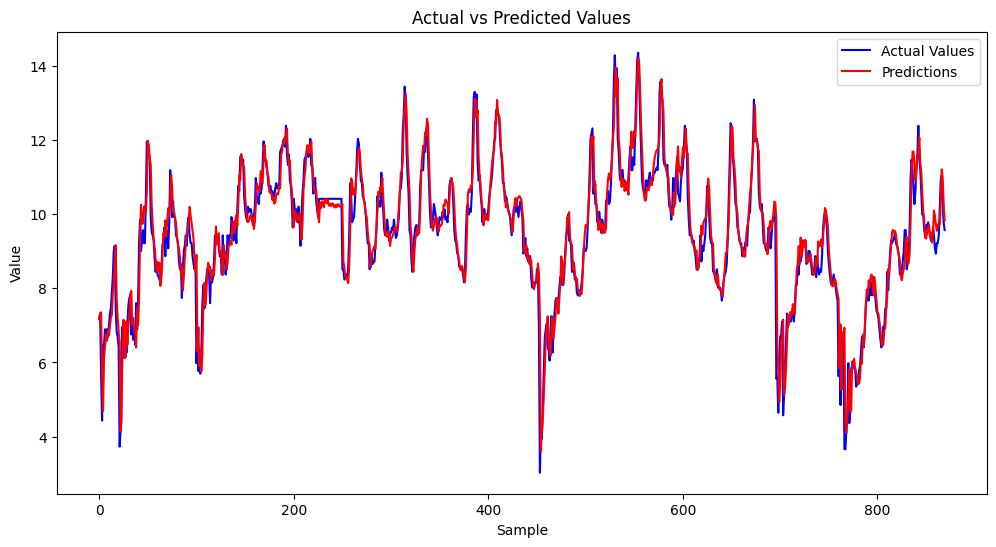

In [86]:
import matplotlib.pyplot as plt




# 获取实际目标值
# Get the actual target value
actual_values = test_targets_tensor.numpy()

# 绘制预测值和实际值
# Plot predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Values', color='blue')
plt.plot(test_predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()
#预测的结果非常好 是因为我们忘记了 使用新生成预测值的数据作为nnar部分的参数，
#而是使用了最初分出来的测试集，其中包括了真实的值。同时也可以看出
#我们的模型中 X输入的MLP的模型占比并不高。可能后续中中测试使用固定的比例也许会更好。
#The prediction results are very good because we forgot to use
#the newly generated predicted value data as the parameters of the nnar part,
# but used the originally separated test set, which included the real values.
#At the same time, it can also be seen that the proportion of MLP models input
# by X is not high in our model. It may be better to use a fixed ratio for
#subsequent mid-to-mid tests.

Mean Error (ME): -1.2721003866743767
Root Mean Squared Error (RMSE): 2.559680832500148
Mean Absolute Error (MAE): 2.1568173534568698
Mean Percentage Error (MPE): -9.621768596572954%
Mean Absolute Percentage Error (MAPE): 23.947803438338752%


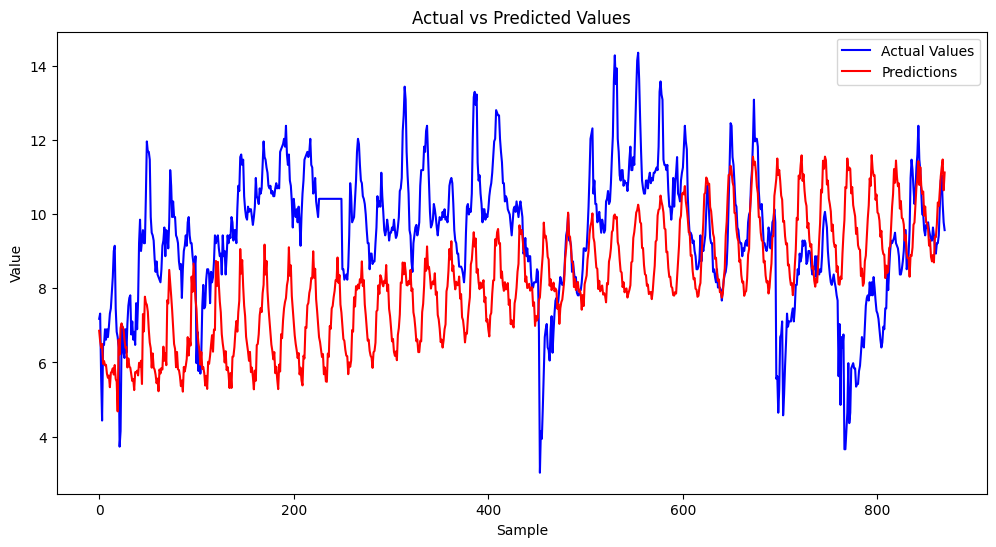

In [87]:
combined_model.eval()

# 从测试集的最后一批数据开始 生成新的NNAR测试集数据
# Generate new NNAR test set data starting from the last batch of data in the test set
# Take the last sample of the training set as the starting point
last_nnar_values = train_nnar_inputs_tensor[-1:]  # 取训练集的最后一个样本作为起点

predictions = []

# 预测测试集的每一步
# Predict each step of the test set
for _ in range(len(test_targets)):
    with torch.no_grad():
        # 使用combined_model进行预测
        # Use combined_model for prediction
        nnar_output = nnar_model(last_nnar_values)
        mlp_output = mlp_model(test_mlp_inputs_tensor[_].unsqueeze(0))
        #combined_output = combined_model.fc(torch.cat((nnar_output, mlp_output), dim=1))
        combined_output = combined_model(last_nnar_values, test_mlp_inputs_tensor[_].unsqueeze(0))

        # 将预测值添加到predictions列表
        # Add predicted values to the predictions list
        predictions.append(combined_output.item())

        # 更新last_nnar_values，将新预测加入并移除最早的值
        # Update last_nnar_values to add new predictions and remove the oldest value
        last_nnar_values = torch.cat((last_nnar_values[:, 1:], combined_output), dim=1)


from sklearn.metrics import mean_squared_error, mean_absolute_error

# ME
me = np.mean(predictions - test_targets.values)

# RMSE
rmse = np.sqrt(mean_squared_error(test_targets.values, predictions))

# MAE
mae = mean_absolute_error(test_targets.values, predictions)

# MPE
mpe = np.mean((predictions - test_targets.values) / test_targets.values) * 100

# MAPE
mape = np.mean(np.abs((predictions - test_targets.values) / test_targets.values)) * 100


print(f"Mean Error (ME): {me}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Percentage Error (MPE): {mpe}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# predictions to numpy for plt
predictions = np.array(predictions)

# plt
plt.figure(figsize=(12, 6))
plt.plot(test_targets.values, label='Actual Values', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()
